In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights= 'imagenet',
                 include_top= False,
                 input_shape=(150,150, 3))

Using TensorFlow backend.


In [0]:
'''
Extracting features from the convolutional base
'''
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

base_dir = r'gdrive/My Drive/face_shape'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale= 1./255)

train_sample_size = 3000
train_batch_size = 30

valid_sample_size = 1_000
valid_batch_size = 20

test_sample_size = 1_000
test_batch_size = 20

def extract_features(directory, sample_count, batch_size):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 5))
    
    generator = datagen.flow_from_directory(
                        directory,
                        target_size= (150, 150),
                        batch_size= batch_size,
                        class_mode= 'categorical')
    
    i=0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size] = features_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        print('Fetched ', (i+1)*batch_size)
        i += 1
        if i*batch_size >= sample_count:
            break
            
    return features, labels


In [4]:
train_features, train_labels = extract_features(train_dir, train_sample_size, train_batch_size)
validation_features, validation_labels = extract_features(validation_dir, valid_sample_size, valid_batch_size,)
test_features, test_labels = extract_features(test_dir, test_sample_size, test_batch_size)

Found 3000 images belonging to 5 classes.
Fetched  30
Fetched  60
Fetched  90
Fetched  120
Fetched  150
Fetched  180
Fetched  210
Fetched  240
Fetched  270
Fetched  300
Fetched  330
Fetched  360
Fetched  390
Fetched  420
Fetched  450
Fetched  480
Fetched  510
Fetched  540
Fetched  570
Fetched  600
Fetched  630
Fetched  660
Fetched  690
Fetched  720
Fetched  750
Fetched  780
Fetched  810
Fetched  840
Fetched  870
Fetched  900
Fetched  930
Fetched  960
Fetched  990
Fetched  1020
Fetched  1050
Fetched  1080
Fetched  1110
Fetched  1140
Fetched  1170
Fetched  1200
Fetched  1230
Fetched  1260
Fetched  1290
Fetched  1320
Fetched  1350
Fetched  1380
Fetched  1410
Fetched  1440
Fetched  1470
Fetched  1500
Fetched  1530
Fetched  1560
Fetched  1590
Fetched  1620
Fetched  1650
Fetched  1680
Fetched  1710
Fetched  1740
Fetched  1770
Fetched  1800
Fetched  1830
Fetched  1860
Fetched  1890
Fetched  1920
Fetched  1950
Fetched  1980
Fetched  2010
Fetched  2040
Fetched  2070
Fetched  2100
Fetched  2130


In [0]:
'''
Reshape the extracted features of shape(samples, 4, 4, 512) into (samples,8192)
before passing to the classifer
'''
train_features = np.reshape(train_features,(train_sample_size, 4*4*512))
validation_features = np.reshape(validation_features,(valid_sample_size, 4*4*512))
test_features = np.reshape(test_features, (test_sample_size, 4*4*512))

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(2048, activation= 'relu', input_dim= 8192))
model.add(layers.Dense(1024, activation= 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation= 'relu'))
model.add(layers.Dense(5,activation= 'softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['acc'])
#model.summary()

In [7]:
history = model.fit(train_features, train_labels, epochs= 30,
                    batch_size= 20, 
                    validation_data= (validation_features, validation_labels))

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 31s 10ms/step - loss: 2.2660 - acc: 0.2730 - val_loss: 1.4194 - val_acc: 0.3980
Epoch 2/30
3000/3000 [==============================] - 33s 11ms/step - loss: 1.4572 - acc: 0.3797 - val_loss: 1.4294 - val_acc: 0.4120
Epoch 3/30
3000/3000 [==============================] - 31s 10ms/step - loss: 1.2996 - acc: 0.4750 - val_loss: 1.3251 - val_acc: 0.4420
Epoch 4/30
3000/3000 [==============================] - 31s 10ms/step - loss: 1.1987 - acc: 0.5260 - val_loss: 1.4883 - val_acc: 0.4190
Epoch 5/30
3000/3000 [==============================] - 30s 10ms/step - loss: 1.0710 - acc: 0.5853 - val_loss: 1.3845 - val_acc: 0.4120
Epoch 6/30
3000/3000 [==============================] - 30s 10ms/step - loss: 0.9560 - acc: 0.6407 - val_loss: 1.4849 - val_acc: 0.4090
Epoch 7/30
3000/3000 [==============================] - 30s 10ms/step - loss: 0.8215 - acc: 0.7020 - val_loss: 2.5238 - val_acc: 0.3800


In [0]:
# Save the model
model.save('vgg16_face_shape_extraction.h5')

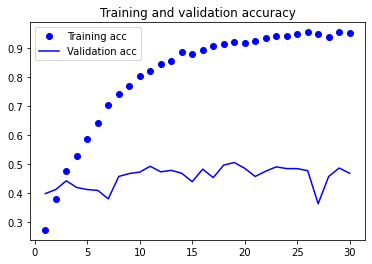

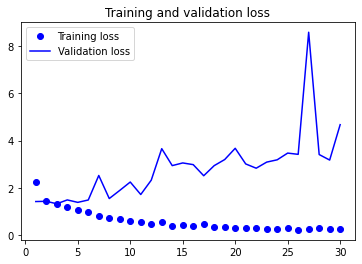

In [9]:

# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

In [10]:
# Evaluating the model 
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Accuracy on test dataset: ', round(test_acc*100), '%' )

1000/1000 [==============================] - 1s 1ms/step
Accuracy on test dataset:  49 %
